# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

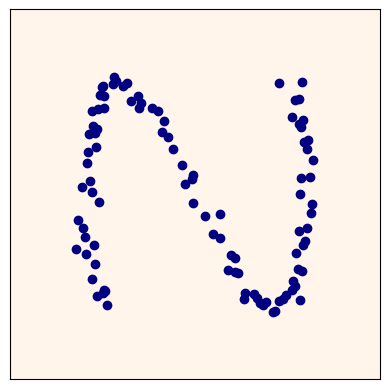

In [32]:
d = 2   # dimension of the data points

"""
# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5
"""


# # Second dataset with 100 points
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

**Answer:**

The `Generator` class in PyTorch is a customizable neural network designed for generative tasks, with the flexibility to specify the number of input/output dimensions, hidden layers, and neurons per layer. It comprises multiple fully connected layers, each followed by an ELU activation function for smooth nonlinearities and stability. The final output layer employs a sigmoid activation to ensure outputs are in the range [0, 1], making it suitable for binary tasks or generating probabilities. Weight initialization is handled via Xavier uniform method, aiding in maintaining activation variance across the network and improving training stability. The architecture allows deployment on different hardware (CPU or GPU) through the `device` parameter, enhancing its versatility and adaptability for different computational environments and tasks.

In [33]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

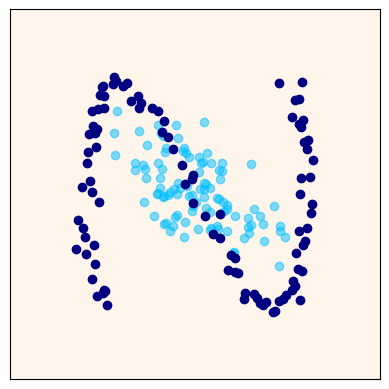

In [34]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
x = G(z)
### ... ###

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [35]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

**Answer:**

Adjusting the `clip_value` in a Wasserstein GAN (WGAN) plays a crucial role in regulating the discriminator's power and ensuring the stability of the training process. The `clip_value` enforces a Lipschitz constraint, which is key to preventing the discriminator from becoming overly dominant, a scenario that could lead to the generator’s gradients vanishing.

- **Lower `clip_value`**: Leads to tighter control, potentially stabilizing training but at the risk of the discriminator becoming too weak, which might fail to effectively challenge the generator.
- **Higher `clip_value`**: Allows the discriminator more flexibility to grow stronger, possibly learning more complex patterns, but can also cause training instability by overpowering the generator.

[0/1000], -0.031919


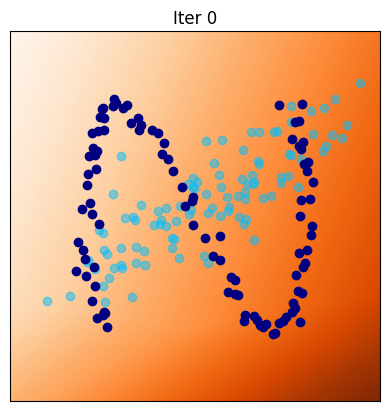

[100/1000], 3.518973


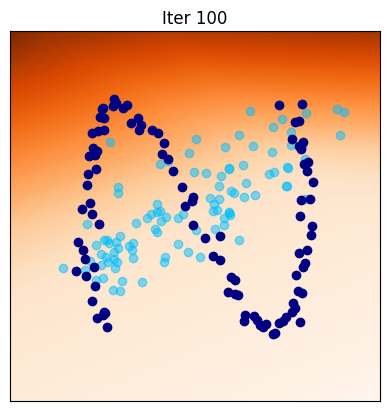

[200/1000], 32.305775


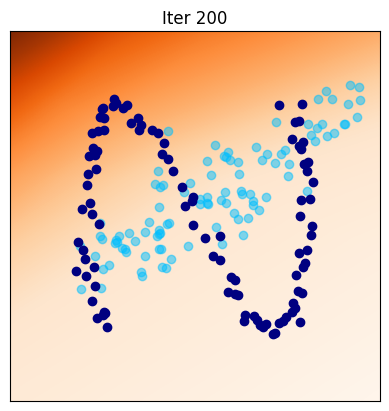

[300/1000], 57.507275


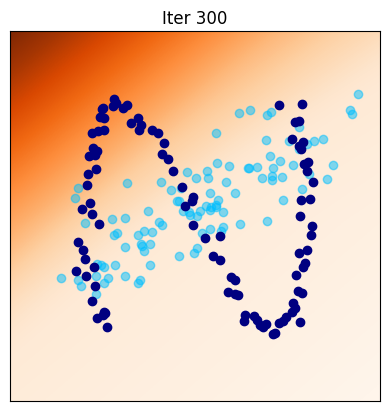

[400/1000], 61.004955


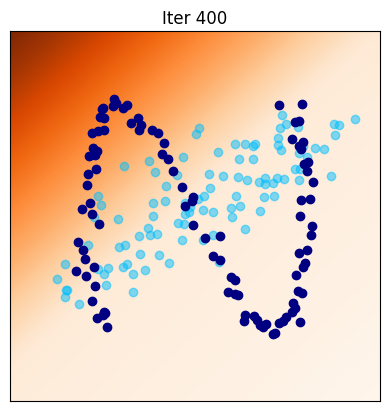

[500/1000], 67.608536


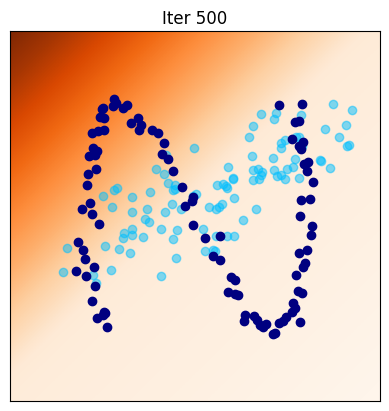

[600/1000], 84.103371


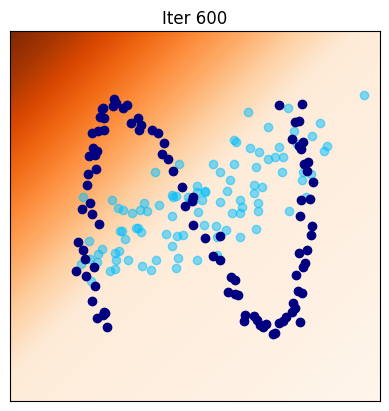

[700/1000], 83.281448


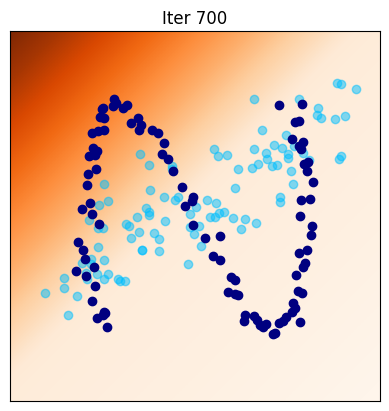

[800/1000], 95.084328


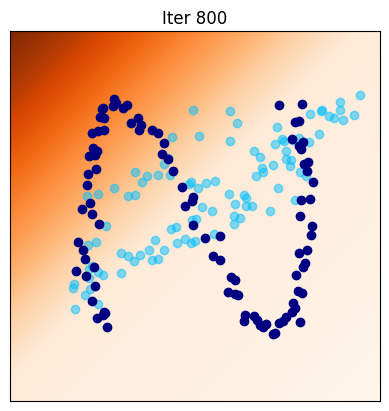

[900/1000], 79.634125


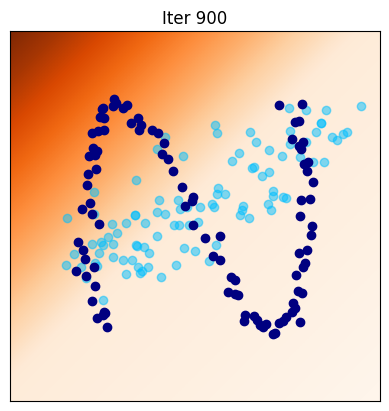

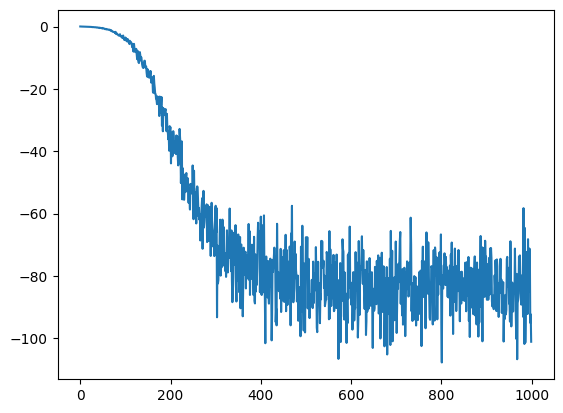

In [36]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = 1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    optimD.zero_grad()

    # Generate fake data
    z = torch.randn(b, n_in, device=device)
    fake_data = G(z)

    # Simulate real data (Replace this with actual data loading in a practical scenario)
    real_data = torch.randn(b, d, device=device)

    # Calculate discriminator's loss
    real_loss = D(real_data).mean()
    fake_loss = D(fake_data).mean()
    Dloss = real_loss - fake_loss
    (-Dloss).backward()  # Minimize negative Wasserstein distance

    optimD.step()

    # Weight Clipping to enforce Lipschitz constraint
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [37]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [38]:
### ... ###
# Initialize Generator and Discriminator
n_in = 10  # Size of the noise vector
d = 2  # Dimensionality of the generated data
n_hid = 10  # Number of hidden units in the generator
nlayers = 3  # Number of layers in the generator

G = Generator(n_in=n_in, n_out=d, n_hid=n_hid, nlayers=nlayers, device=device).to(device)
D = Discriminator(n_in=d, n_hid=n_hid).to(device)

# Load trained weights into D and G or assume they are already trained for this example

# Generate data
b = 100  # Batch size
x = torch.randn(b, d, device=device)  # Real data sample (assuming normal distribution for simplicity)
z = torch.randn(b, n_in, device=device)  # Noise vector for generating fake data
y = G(z)  # Generated data

# Calculate and print the Lipschitz constant
lipschitz_constant = lipconstant(D, x, y)
print("Estimated Lipschitz constant of the discriminator:", lipschitz_constant.item())


Estimated Lipschitz constant of the discriminator: 0.08415330946445465


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [40]:
import torch.autograd as autograd

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # Shrink vectors if they are too large
    if n > b:
        y = y[:b, :]
        n = b
    else:
        x = x[:n, :]
        b = n

    # Compute interpolated points
    alpha = torch.rand((b, 1), device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

    # Calculate the probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    grad_out = torch.ones(Di.size(), device=device)
    gradients = autograd.grad(outputs=Di, inputs=interp, grad_outputs=grad_out,
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Add a small epsilon to the sum of squares of gradients to avoid numerical instability near zero
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    # Compute the gradient penalty as the mean squared distance from 1 of the gradient norms
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Assuming D is your discriminator model, x is real data, and y is generated data
# Make sure D, x, and y are on the correct device and are in the correct format before calling this function
print("Gradient Penalty:", gradient_penalty(D, x, y).item())


Gradient Penalty: 0.8515682816505432


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=8.6189, Lip(D)=0.0795


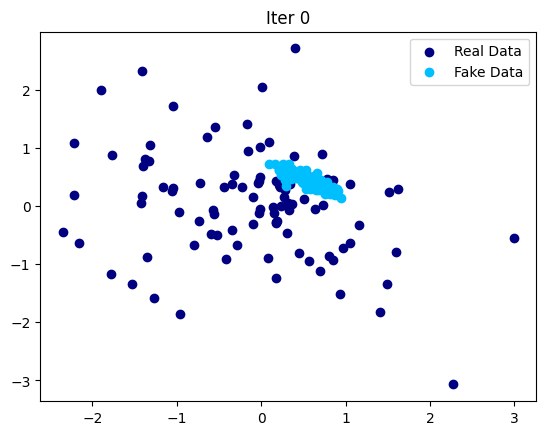

[100/1000], Dloss=2.0225, Lip(D)=0.8278


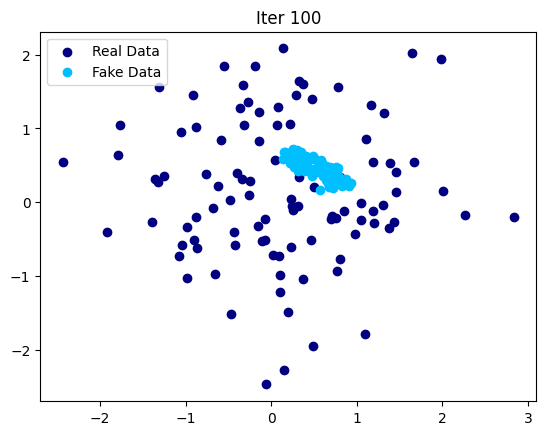

[200/1000], Dloss=1.5762, Lip(D)=0.8575


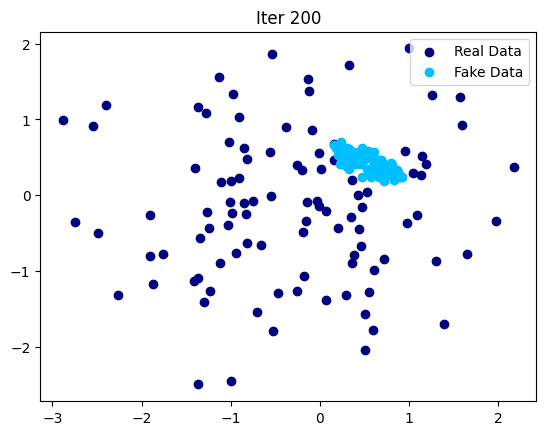

[300/1000], Dloss=0.4831, Lip(D)=0.9232


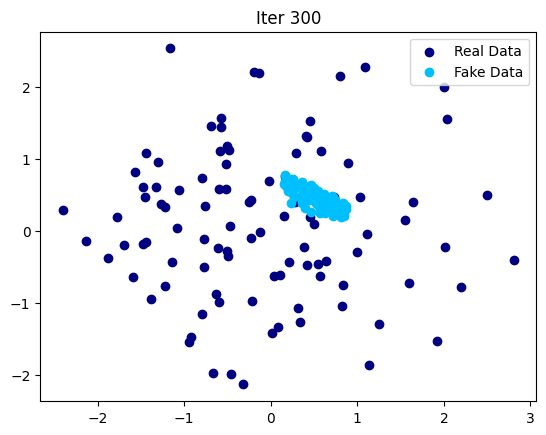

[400/1000], Dloss=0.2816, Lip(D)=0.9861


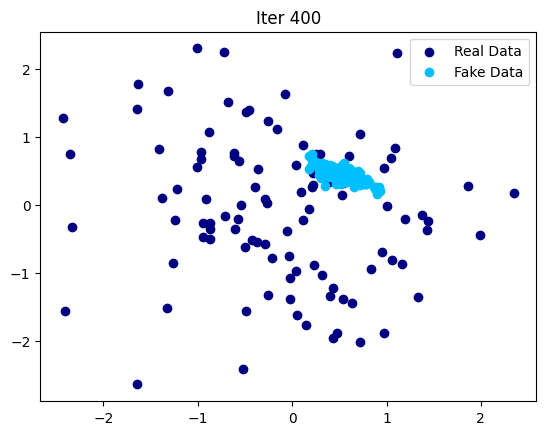

[500/1000], Dloss=-0.2430, Lip(D)=1.0148


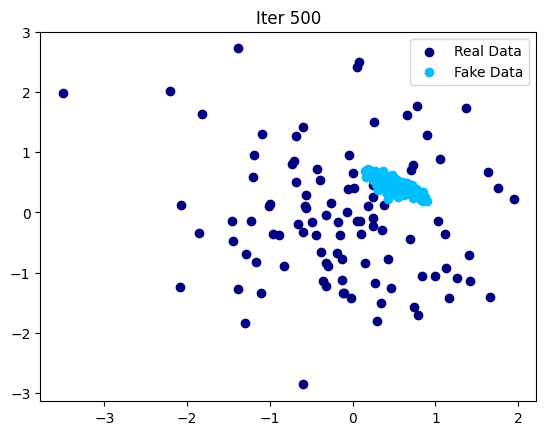

[600/1000], Dloss=-0.9847, Lip(D)=1.0353


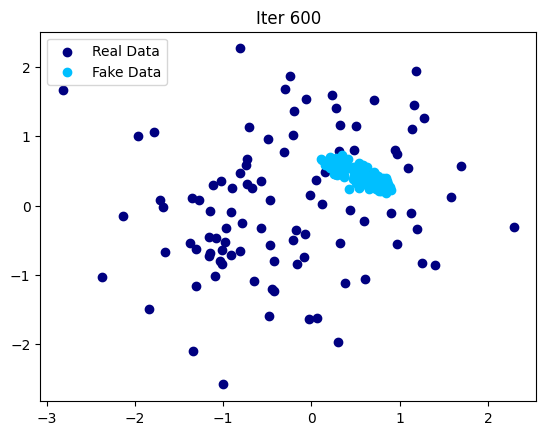

[700/1000], Dloss=-0.9621, Lip(D)=1.0397


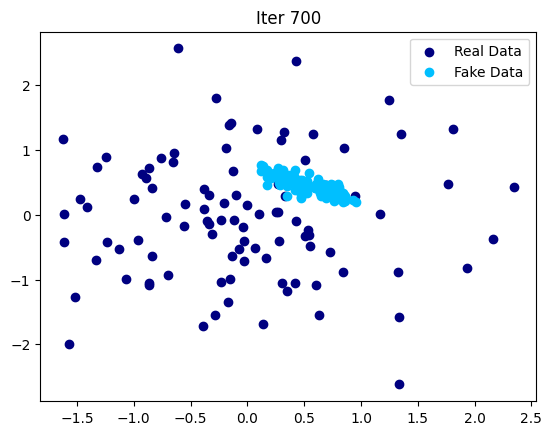

[800/1000], Dloss=-1.0138, Lip(D)=1.0327


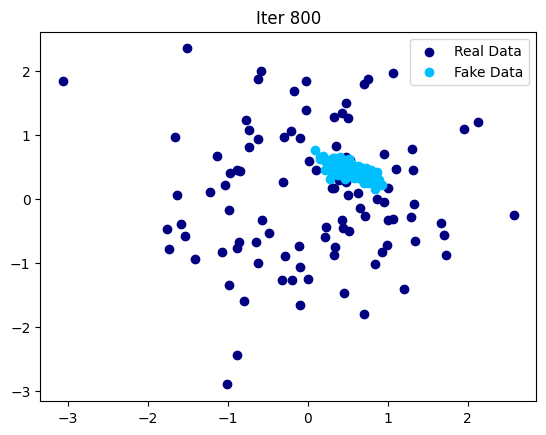

[900/1000], Dloss=-1.0385, Lip(D)=1.0413


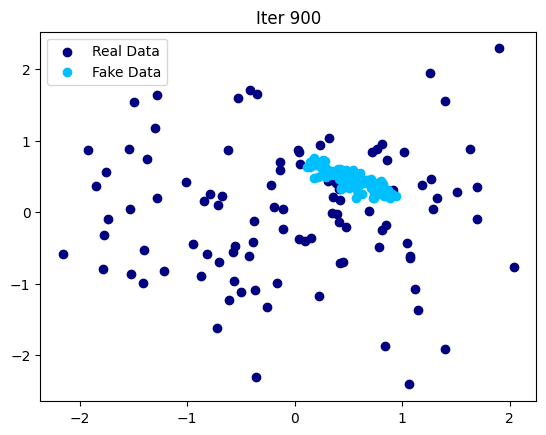

Final estimated Lipschitz constant =  1.0419448614120483


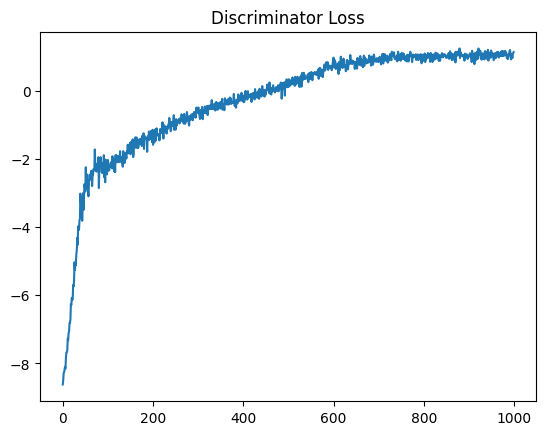

In [43]:

torch.manual_seed(1)  # Initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device).to(device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# Parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000
gpw = 10  # Gradient penalty weight

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # Display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []
for iter in range(niterD):
    optimD.zero_grad()

    # Generate fake data and get real data
    z = torch.randn(b, n_in, device=device)
    x_fake = G(z).detach()  # Detached to prevent gradients from flowing into G
    x_real = torch.randn(b, d, device=device)  # Simulated real data

    # Compute loss on real and fake data
    real_loss = -torch.mean(D(x_real))
    fake_loss = torch.mean(D(x_fake))

    # Compute the gradient penalty
    gp = gradient_penalty(D, x_real, x_fake)
    gp_loss = gpw * gp  # Apply gradient penalty weight

    # Total discriminator loss
    Dloss = real_loss + fake_loss + gp_loss
    Dloss.backward()
    optimD.step()

    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        lip_const = lipconstant(D, x_real, x_fake).item()
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst, lip_const))

        # Visualize real and generated data instead of discriminator heatmap
        fig = plt.figure(dpi=100)
        plt.scatter(x_real[:, 0].cpu(), x_real[:, 1].cpu(), c='navy', label='Real Data')
        plt.scatter(x_fake[:, 0].cpu(), x_fake[:, 1].cpu(), c='deepskyblue', label='Fake Data')
        plt.title(f'Iter {iter}')
        plt.legend()
        plt.show()

print('Final estimated Lipschitz constant = ', lipconstant(D, x_real, x_fake).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator Loss')
plt.show()


## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[5/100] 	Loss_D: -3.5025	Loss_G: 1.5997	Lip(D)=5.6460


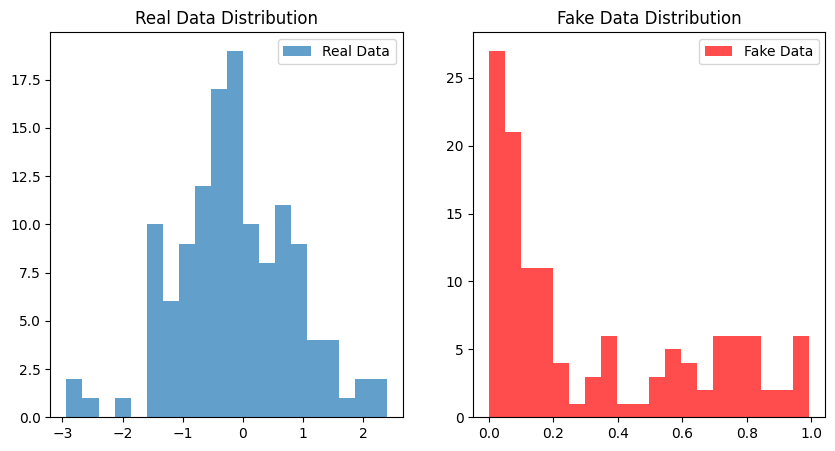

[10/100] 	Loss_D: -1.9794	Loss_G: 1.5597	Lip(D)=5.2195


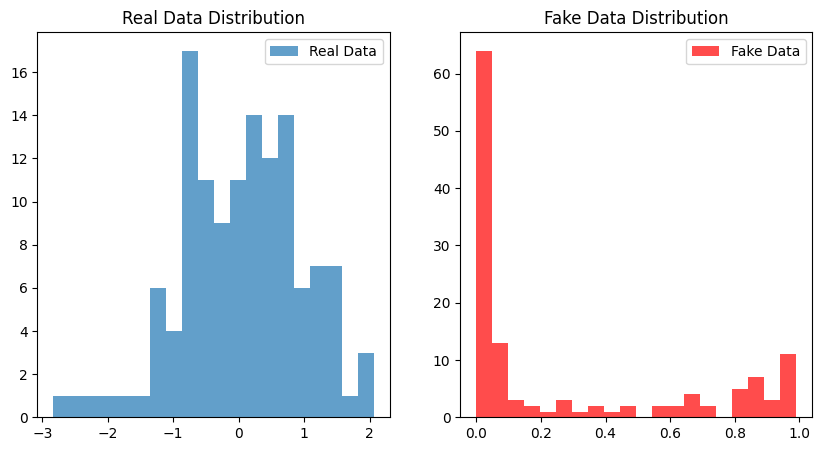

[15/100] 	Loss_D: -2.4877	Loss_G: 1.6619	Lip(D)=4.7215


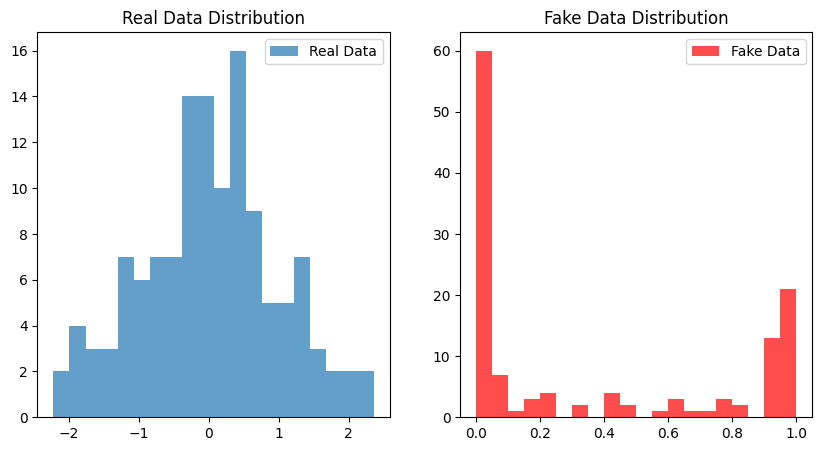

[20/100] 	Loss_D: -2.9952	Loss_G: -0.7409	Lip(D)=5.0534


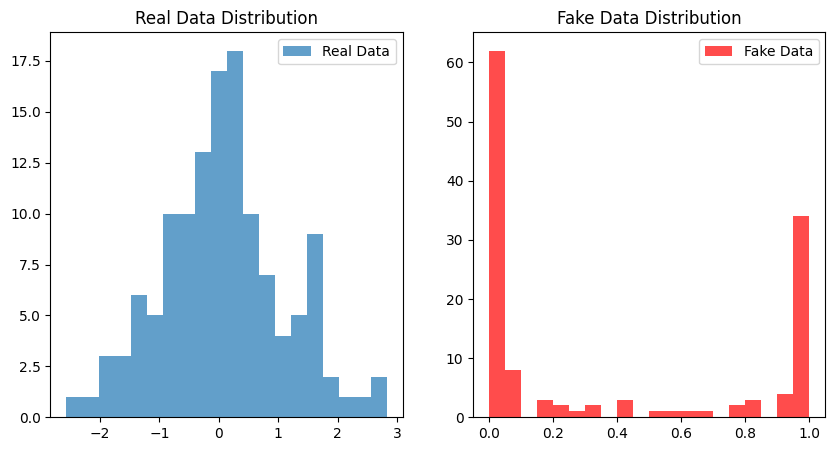

[25/100] 	Loss_D: -2.6591	Loss_G: 5.4041	Lip(D)=5.0733


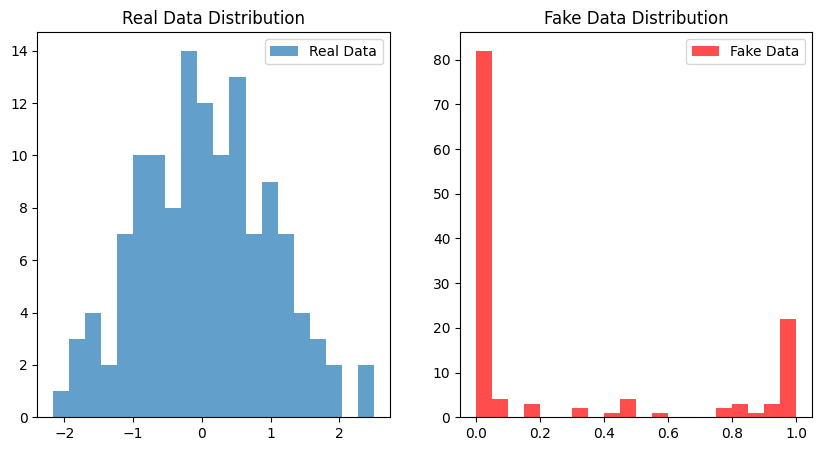

[30/100] 	Loss_D: -2.8347	Loss_G: 7.1998	Lip(D)=4.6775


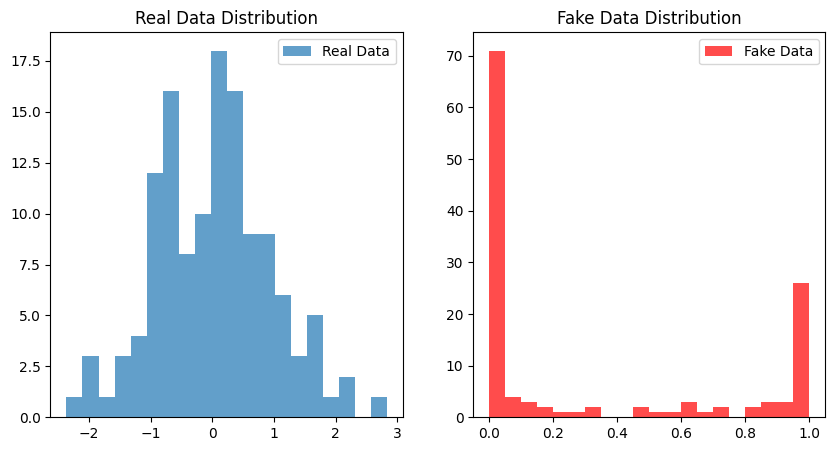

[35/100] 	Loss_D: -2.5865	Loss_G: 5.0017	Lip(D)=5.0473


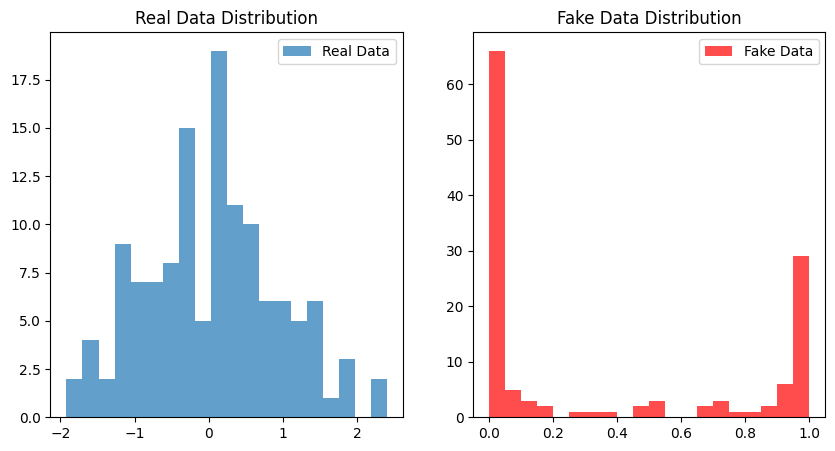

[40/100] 	Loss_D: -2.6508	Loss_G: 4.2993	Lip(D)=5.1260


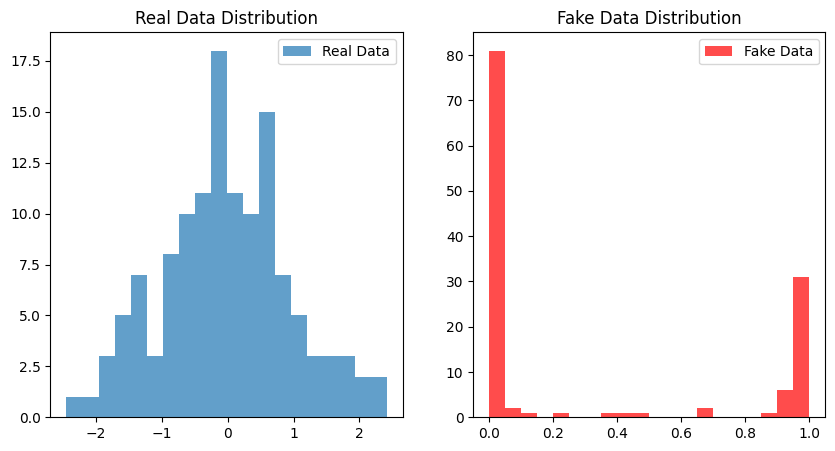

[45/100] 	Loss_D: -3.1581	Loss_G: 5.1521	Lip(D)=5.1063


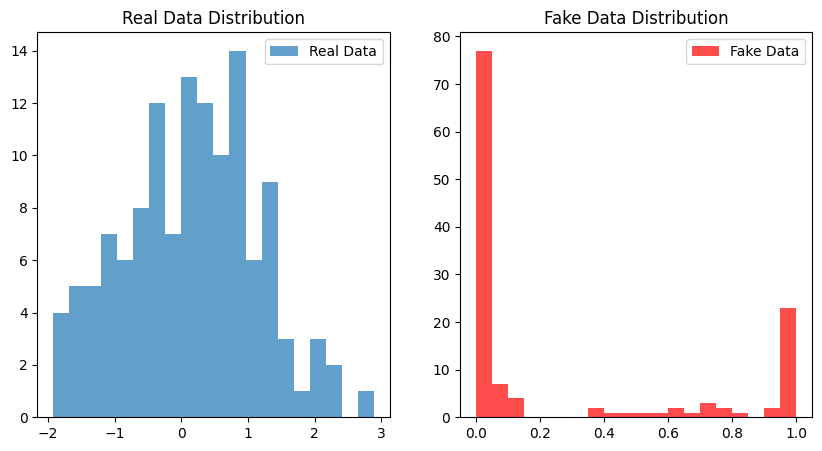

[50/100] 	Loss_D: -3.1828	Loss_G: 5.8978	Lip(D)=5.3640


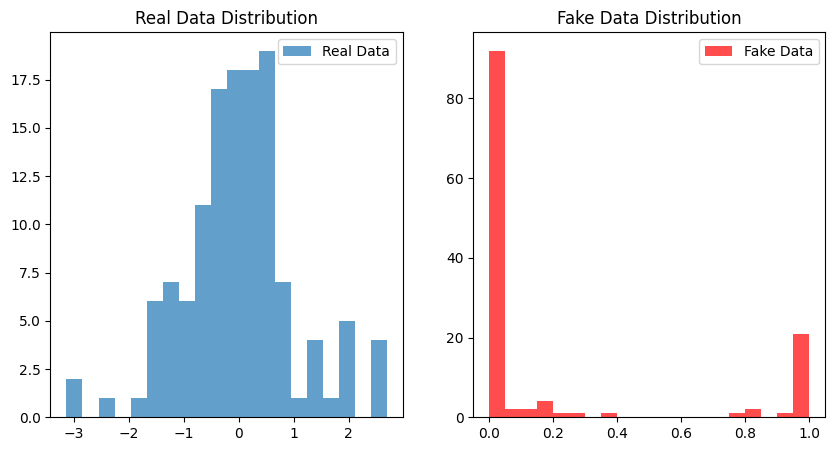

[55/100] 	Loss_D: -2.8851	Loss_G: 3.3666	Lip(D)=4.6967


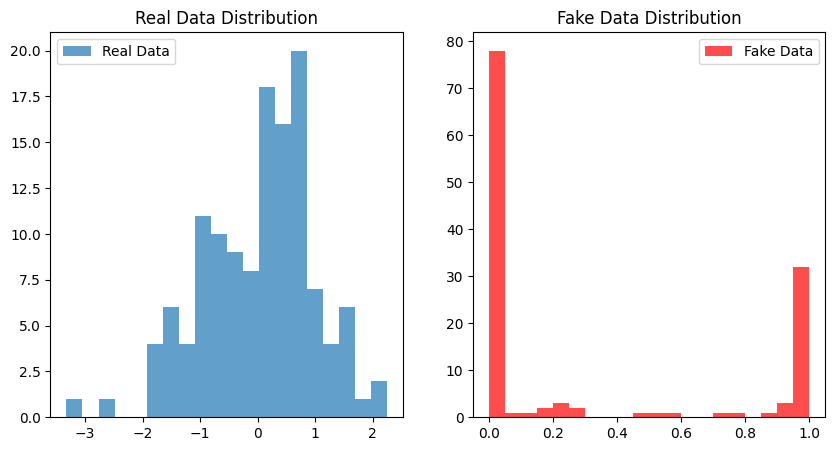

[60/100] 	Loss_D: -3.7287	Loss_G: 3.4554	Lip(D)=5.3616


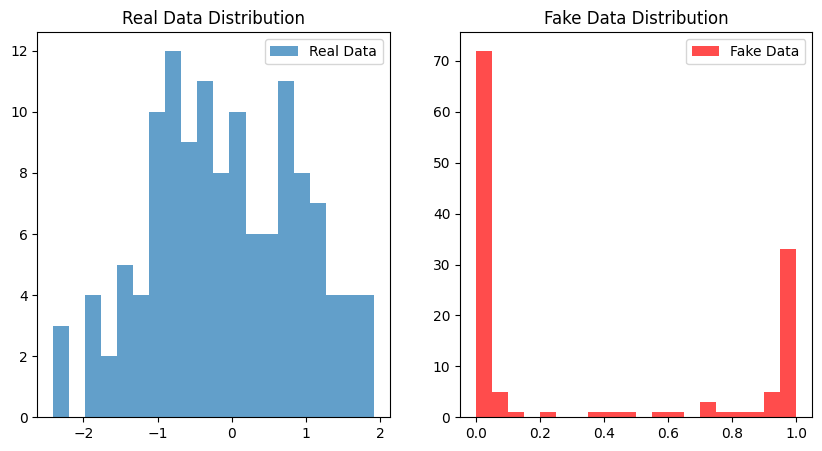

[65/100] 	Loss_D: -2.6458	Loss_G: 2.6112	Lip(D)=5.1911


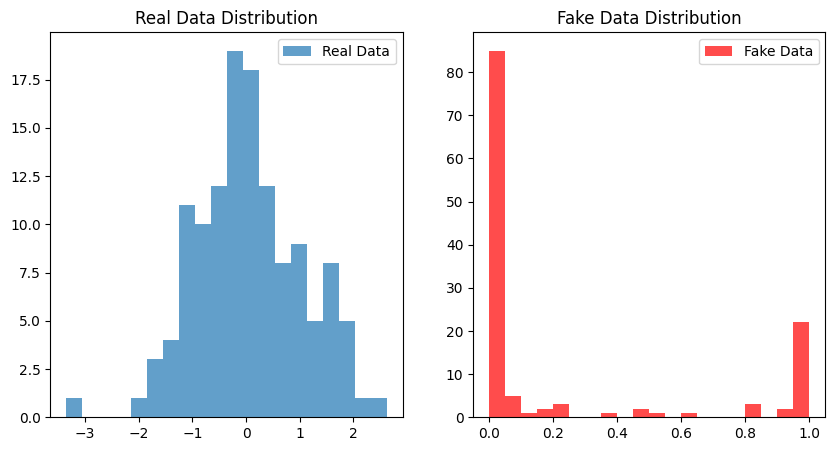

[70/100] 	Loss_D: -2.8235	Loss_G: 0.7881	Lip(D)=4.8833


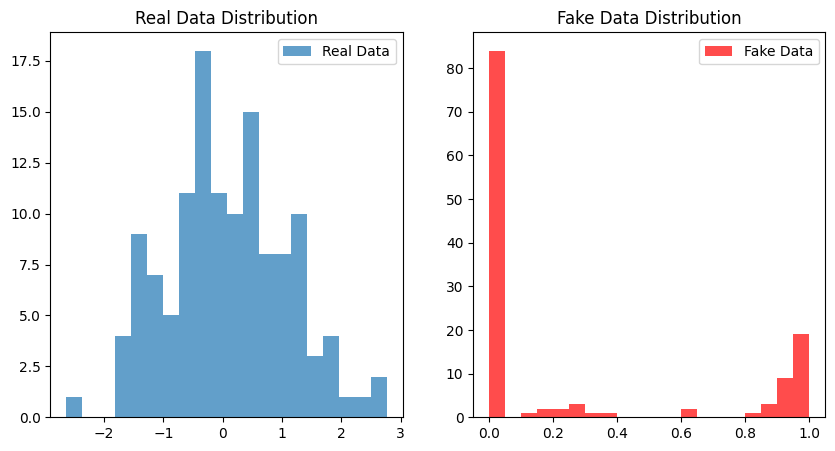

[75/100] 	Loss_D: -2.2551	Loss_G: 0.2626	Lip(D)=4.9002


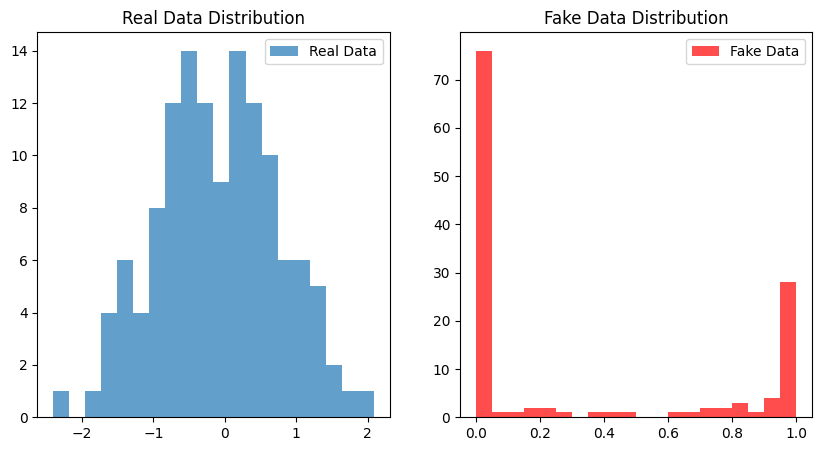

[80/100] 	Loss_D: -3.3911	Loss_G: -0.2241	Lip(D)=5.0950


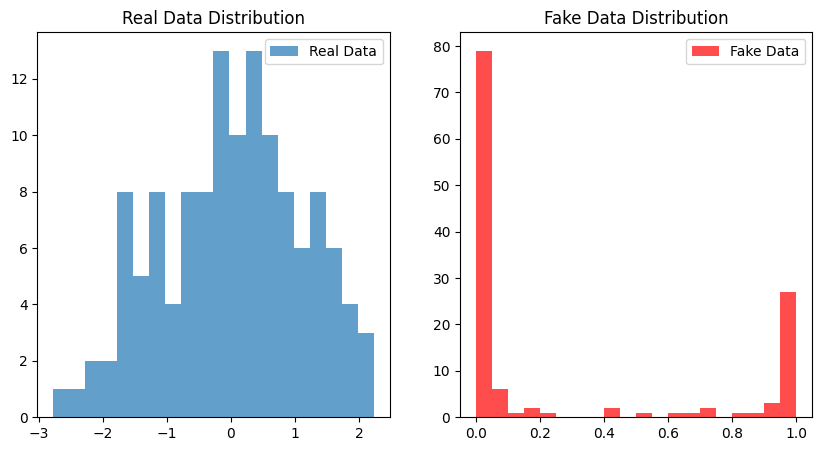

[85/100] 	Loss_D: -3.5210	Loss_G: -0.2294	Lip(D)=5.4244


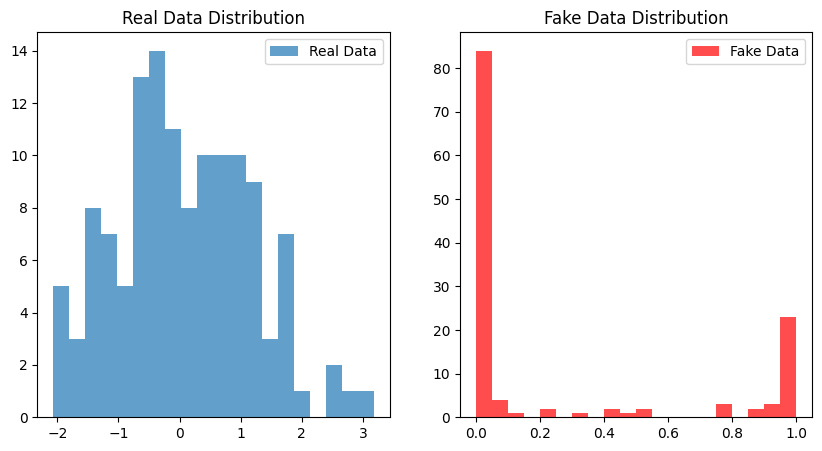

[90/100] 	Loss_D: -3.1728	Loss_G: -1.0339	Lip(D)=4.9956


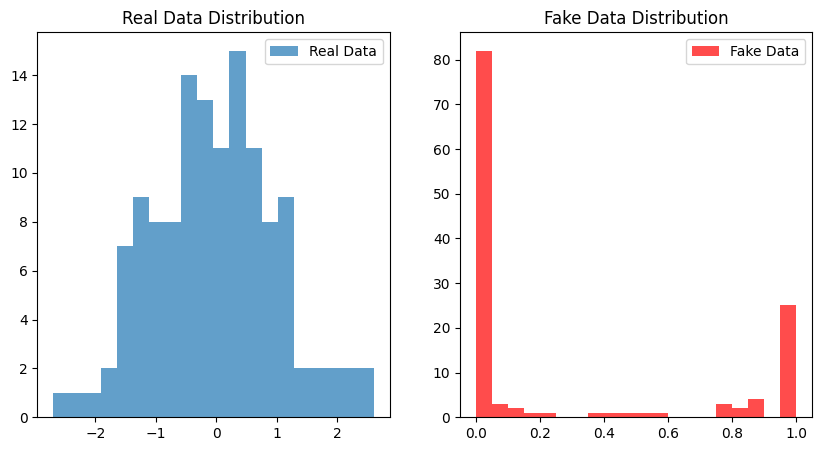

[95/100] 	Loss_D: -2.2511	Loss_G: -0.7722	Lip(D)=4.7130


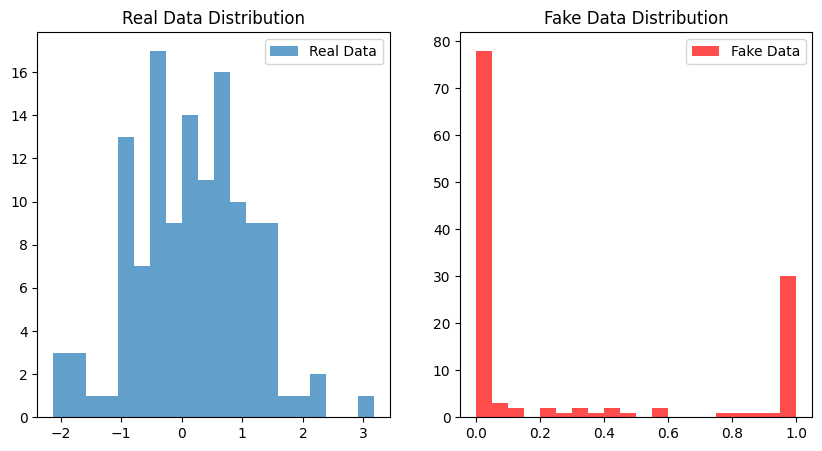

[100/100] 	Loss_D: -3.2383	Loss_G: -1.2136	Lip(D)=5.0727


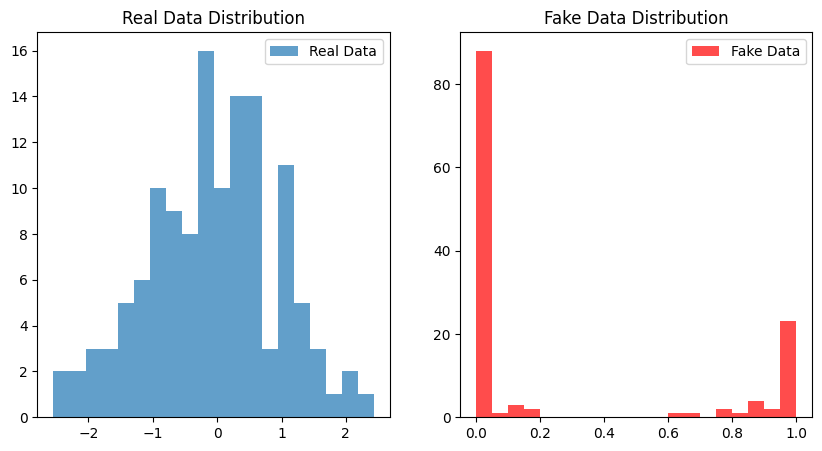

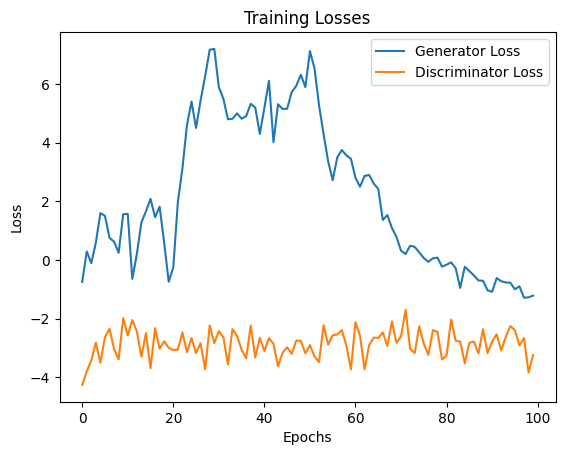

<All keys matched successfully>

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)  # Initialize random seed for reproducibility

# Parameters
n_epochs = 100
niterD = 1000
niterG = 10
gpw = 0.1  # Gradient penalty weight
b = 64     # Batch size for generator input and real data

lr = 0.002      # Learning rate for generator
lrdisc = 0.002  # Learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

n_in = 10  # Dimensionality of noise input to the generator
d = 2      # Dimensionality of the output from the generator (and input to the discriminator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device).to(device)
D = Discriminator(n_in=d, n_hid=10).to(device)

optimG = optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 5  # Frequency of displaying training results and outputs

# Main training loop
for epoch in range(1, n_epochs + 1):
    ### Train discriminator for niterD iterations
    for _ in range(niterD):
        optimD.zero_grad()

        # Generate fake data and sample real data
        z = torch.randn(b, n_in, device=device)
        x_fake = G(z).detach()
        x_real = torch.randn(b, d, device=device)  # Simulating real data

        # Compute losses
        real_loss = -torch.mean(D(x_real))
        fake_loss = torch.mean(D(x_fake))
        gp = gradient_penalty(D, x_real, x_fake)
        Dloss = real_loss + fake_loss + gpw * gp
        Dloss.backward()
        optimD.step()

    ### Train generator for niterG iterations
    for _ in range(niterG):
        optimG.zero_grad()

        # Generate fake data
        x_fake = G(z)
        G_loss = -torch.mean(D(x_fake))  # Maximize the discriminator's mistake
        G_loss.backward()
        optimG.step()

    # Record losses
    Glosses.append(G_loss.item())
    Dlosses.append(Dloss.item())

    # Output training stats and visualize results
    if epoch % iter_display == 0 or epoch == n_epochs:
        lip_const = lipconstant(D, x_real, x_fake).item()
        print(f'[{epoch}/{n_epochs}] \tLoss_D: {Dloss.item():.4f}\tLoss_G: {G_loss.item():.4f}\tLip(D)={lip_const:.4f}')

        # Visualization of real and generated data
        x_real_flat = x_real.view(-1).detach().cpu().numpy()
        x_fake_flat = x_fake.view(-1).detach().cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Real Data Distribution')
        plt.hist(x_real_flat, bins=20, alpha=0.7, label='Real Data')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Fake Data Distribution')
        plt.hist(x_fake_flat, bins=20, alpha=0.7, color='red', label='Fake Data')
        plt.legend()
        plt.show()

# Plot training losses
plt.figure(dpi=100)
plt.plot(Glosses, label='Generator Loss')
plt.plot(Dlosses, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained generator
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())


## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

**Answer:**

In training a Wasserstein GAN with Gradient Penalty (WGAN-GP), it's crucial to finely tune hyperparameters such as learning rates, update frequencies, gradient penalty weights, and batch sizes for optimal performance. Higher learning rates for the discriminator, more frequent discriminator updates, and larger batch sizes generally contribute to a more stable training process. Strategic experimentation with these parameters, alongside regular monitoring of training metrics like the Lipschitz constant and Wasserstein distance, is essential. Adapting these parameters dynamically based on ongoing training results can lead to improved stability and effectiveness of the generative models.

Completed training with discriminator learning rate: 0.001
Completed training with discriminator learning rate: 0.002
Completed training with discriminator learning rate: 0.005
Completed training with discriminator learning rate: 0.01


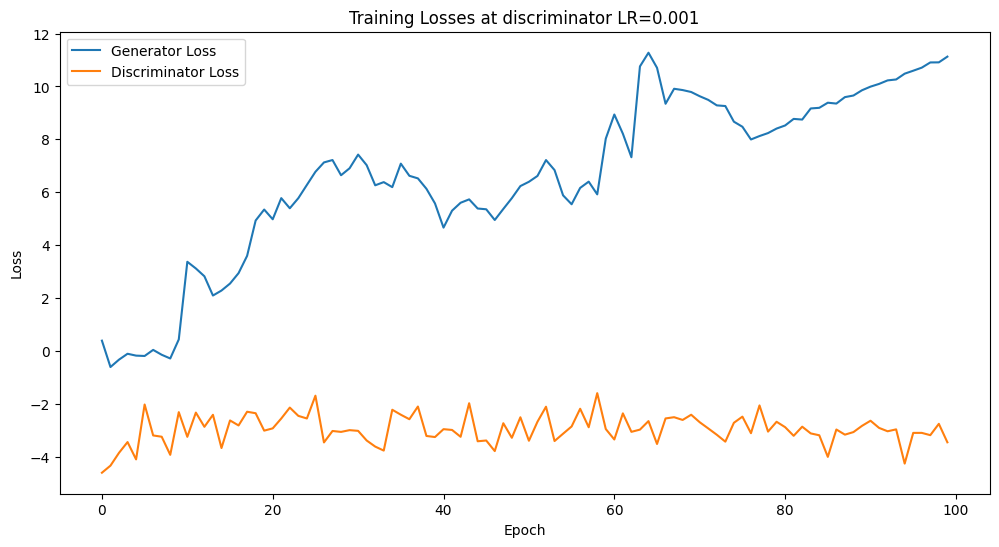

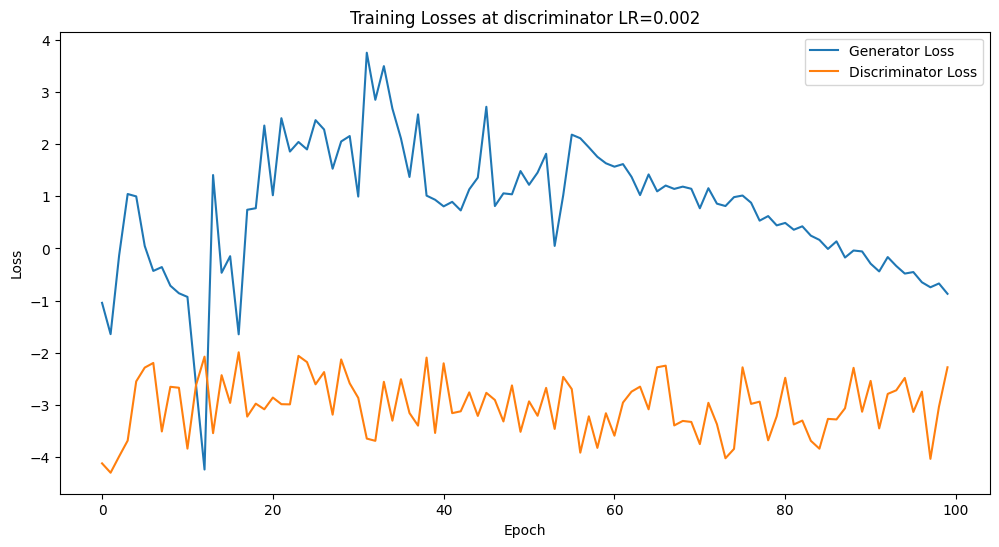

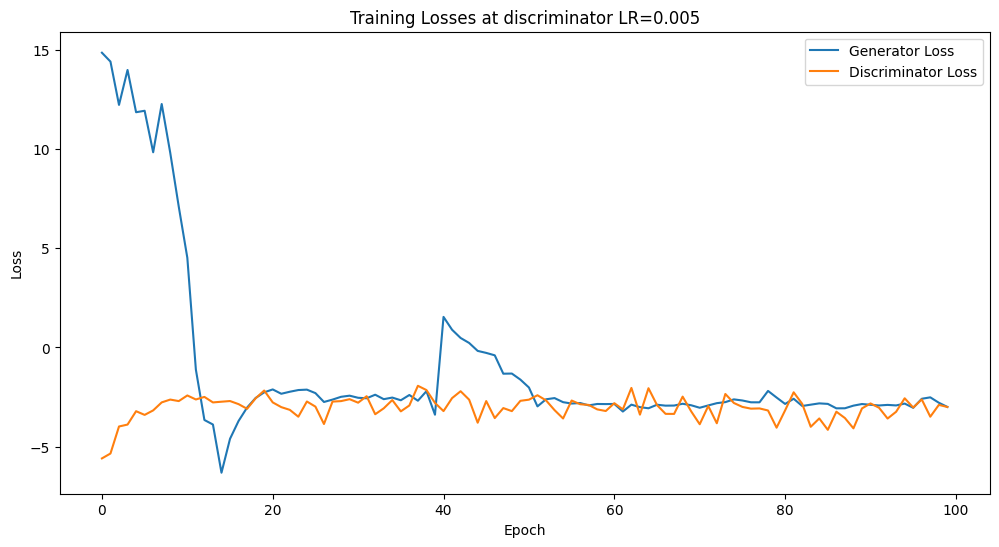

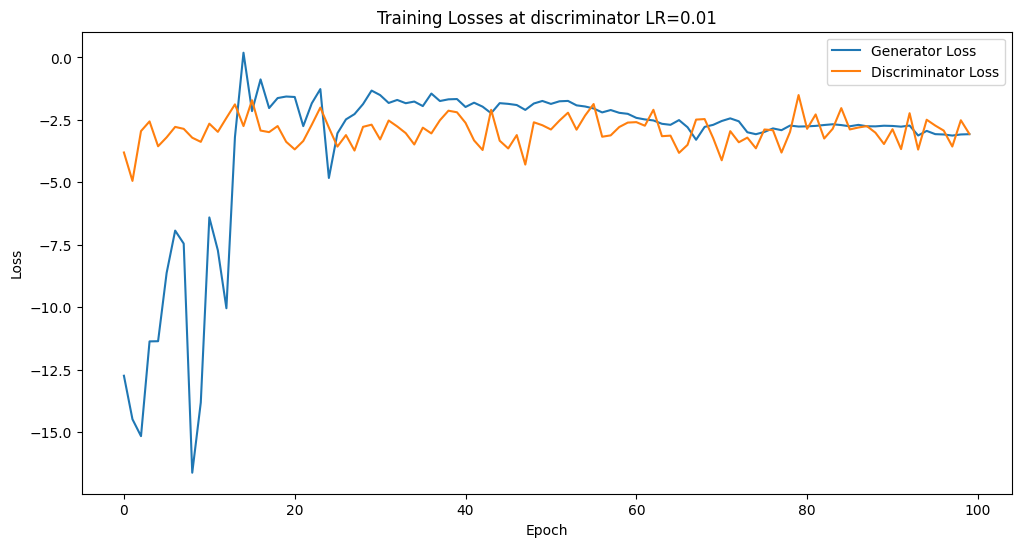

In [50]:
# Setup
torch.manual_seed(1)  # For reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
n_epochs = 100
niterD = 1000  # Number of discriminator updates per epoch
niterG = 10    # Number of generator updates per epoch
gpw = 0.1      # Gradient penalty weight
b = 64         # Batch size

lr = 0.002     # Learning rate for the generator
beta_1 = 0.5
beta_2 = 0.999
n_in = 10      # Input noise dimension
d = 2          # Output dimension

learning_rates = [0.001, 0.002, 0.005, 0.01]  # Different learning rates to test for discriminator
results = {}

for lrdisc in learning_rates:
    # Reinitialize models and optimizers
    D = Discriminator(n_in=d, n_hid=10).to(device)
    G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device).to(device)

    optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
    optimG = optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

    # Reset loss trackers
    Glosses, Dlosses = [], []

    # Training loop
    for epoch in range(n_epochs):
        ### Train discriminator for niterD iterations
        for _ in range(niterD):
            optimD.zero_grad()

            # Sample noise and generate fake data
            z = torch.randn(b, n_in, device=device)
            x_fake = G(z).detach()
            x_real = torch.randn(b, d, device=device)  # Simulating real data

            # Compute losses
            real_loss = -torch.mean(D(x_real))
            fake_loss = torch.mean(D(x_fake))
            gp = gradient_penalty(D, x_real, x_fake)
            Dloss = real_loss + fake_loss + gpw * gp
            Dloss.backward()
            optimD.step()

        ### Train generator for niterG iterations
        for _ in range(niterG):
            optimG.zero_grad()

            # Generate fake data
            x_fake = G(z)
            G_loss = -torch.mean(D(x_fake))  # Maximize the discriminator's mistake
            G_loss.backward()
            optimG.step()

        # Record losses for this epoch
        Glosses.append(G_loss.item())
        Dlosses.append(Dloss.item())

    # Store results
    results[lrdisc] = (Glosses, Dlosses)
    print(f"Completed training with discriminator learning rate: {lrdisc}")

# Visualize the results
for lr, (Glosses, Dlosses) in results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(Glosses, label='Generator Loss')
    plt.plot(Dlosses, label='Discriminator Loss')
    plt.title(f'Training Losses at discriminator LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... ###


    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

In [ ]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=100
niterG=1

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()